# 💼 성인 연봉 데이터 분석 with AutoGluon (v1.4)

이 노트북에서는 **Adult Income (salary2.csv)** 데이터를 이용해서  
`AutoGluon` 라이브러리로 **연봉이 50K 초과인지 여부(>50K vs <=50K)를 자동으로 예측하는 모델**을 만들어 본다.

## ✅ 학습 목표

1. AutoGluon Tabular의 기본 사용법 이해  
2. 기존에 하던 수작업 전처리 / 모델링(DecisionTree, RandomForest 등)과의 차이 이해  
3. 리더보드(leaderboard)로 여러 모델의 성능을 한 번에 비교하는 방법 익히기  
4. Feature Importance로 **연봉에 영향을 많이 주는 변수** 해석하기


## 1. AutoGluon 설치

수업 환경(예: 구글 코랩, 로컬 PC 가상환경 등)에 따라 다음 명령어로 AutoGluon을 설치한다.

> **⚠️ 주의:** AutoGluon은 설치 시간이 조금 걸릴 수 있다.  
> 가능한 한 **새 가상환경(venv / conda)**에서 사용하는 것을 추천한다.

```bash
!pip install -U "torch"
!pip install "autogluon.tabular[fastai]==1.4.0"
```

아래 코드는 노트북에서 직접 설치하고 싶을 때 사용하는 예시이다.  
(이미 설치했다면 다시 실행할 필요는 없다.)


In [4]:
# !pip install -U "torch"
# !pip install "autogluon.tabular[fastai]==1.4.0"
# 설치가 오래 걸릴 수 있으니, 필요할 때만 실행하세요.

## 2. 라이브러리 불러오기

데이터 분석에 필요한 기본 라이브러리와 AutoGluon을 불러온다.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from autogluon.tabular import TabularPredictor

pd.set_option("display.max_columns", 50)


C:\Users\haram\miniforge3\envs\fintech\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. 데이터 불러오기 및 기본 전처리

### 3.1 salary2.csv 불러오기

- Adult Income 기반의 연봉 데이터셋을 사용한다.
- 파일 위치는 `./data/salary2.csv` 라고 가정한다.


In [6]:
# 데이터 불러오기
data = pd.read_csv("./data/salary2.csv")

print("데이터 크기:", data.shape)
data.head()


데이터 크기: (48842, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


### 3.2 중복 제거 & 결측값 제거

- **중복 행(drop_duplicates)**: 같은 사람이 여러 번 기록되었을 수 있어서 제거
- **결측값 제거(dropna)**: 결측치가 있는 행은 간단하게 제거 (수업용 예제라서)
- 인덱스를 다시 0부터 재설정한다.


In [7]:
# 중복 제거
data = data.drop_duplicates()

# 결측값 제거
data = data.dropna()

# 인덱스 재설정
data = data.reset_index(drop=True)

print("전처리 후 데이터 크기:", data.shape)
data.head()


전처리 후 데이터 크기: (39240, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


### 3.3 타깃 변수 `class` 이진 변환

원본 데이터의 `class` 컬럼은 문자열 형태이다. (예: `' >50K'`, `' <=50K'`)

- `' >50K'`  →  **1 (연봉 50K 초과)**  
- 그 외(예: `' <=50K'`) → **0 (연봉 50K 이하)**

이렇게 바꿔야 머신러닝 모델이 **이진 분류 문제(binary classification)**로 다룰 수 있다.


In [8]:
# class 컬럼을 0/1로 변환
data['class'] = data['class'].apply(lambda x: 1 if x.strip() == '>50K' or x.strip() == '>50K.' or x.strip() == '>50K' else 0)

# 타깃 분포 확인
data['class'].value_counts()


class
0    29265
1     9975
Name: count, dtype: int64

### 3.4 간단한 EDA (타깃 비율 확인)

연봉이 50K 초과인 사람(1)과 그렇지 않은 사람(0)의 비율을 확인하여  
**클래스 불균형(class imbalance)**이 있는지 살펴본다.


In [9]:
target_counts = data['class'].value_counts().rename(index={0: '≤50K', 1: '>50K'})
target_counts


class
≤50K    29265
>50K     9975
Name: count, dtype: int64

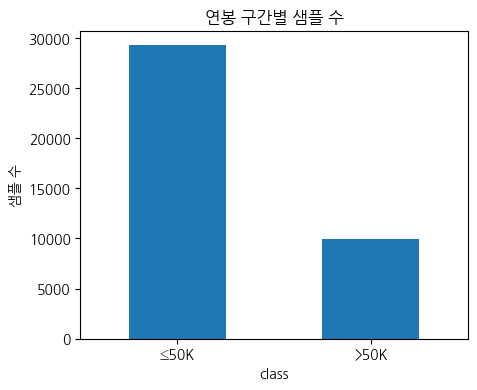

In [10]:
# 막대 그래프로 시각화
plt.figure(figsize=(5,4))
target_counts.plot(kind='bar')
plt.title("연봉 구간별 샘플 수")
plt.ylabel("샘플 수")
plt.xticks(rotation=0)
plt.show()


## 4. 학습용 / 평가용 데이터 분리

머신러닝 모델의 **일반화 성능**을 평가하기 위해 데이터셋을 나눈다.

- `train_df` : 모델 학습에 사용 (60%)
- `test_df` : 최종 성능 평가에 사용 (40%)
- `stratify=y` 옵션으로 타깃 비율을 유지한 채로 나눈다.


In [11]:
# 전체 데이터 복사
df = data.copy()

# 학습/테스트 분할
train_df, test_df = train_test_split(
    df,
    test_size=0.4,
    stratify=df['class'],
    random_state=10
)

print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)

train_df.head()


train_df shape: (23544, 14)
test_df shape: (15696, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
21251,32,State-gov,7th-8th,4,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,19,United-States,0
3994,38,State-gov,Some-college,10,Divorced,Exec-managerial,Unmarried,White,Female,0,0,40,United-States,0
1871,58,Private,Bachelors,13,Widowed,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,1
16563,27,Private,HS-grad,9,Never-married,Craft-repair,Own-child,White,Female,0,0,45,United-States,0
16892,46,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,1


## 5. AutoGluon Tabular 소개

`AutoGluon`은 **AutoML 라이브러리**로, 아래 작업들을 자동으로 해준다.

- 범주형/수치형 변수 자동 인코딩
- 여러 모델(GBM, CatBoost, XGBoost 등) 자동 탐색
- 하이퍼파라미터 튜닝
- 여러 모델을 앙상블하여 최종 성능 향상

우리는 단지:
1. **데이터프레임** 전체와  
2. **타깃 컬럼 이름(label)** 만 넘겨주면 된다.

이제 `TabularPredictor`를 이용해서 모델을 학습해보자.


### 5.1 TabularPredictor 설정 및 학습

- `label='class'` : 예측할 타깃 컬럼 이름  
- `problem_type='binary'` : 이진 분류 문제  
- `eval_metric='f1'` : 불균형 데이터에 유리한 F1 점수를 기준으로 최적 모델 선택  
- `presets="medium_quality_faster_train"` : 적당한 속도 + 괜찮은 성능  
- `time_limit=600` : 최대 학습 시간(초) 설정 (환경에 따라 조정 가능)


In [12]:
save_path = "autogluon_salary_model/"  # 모델 및 로그 저장 경로

predictor = TabularPredictor(
    label='class',           # 타깃 컬럼 이름
    problem_type='binary',   # 이진분류
    eval_metric='f1',        # 평가 지표 (불균형 데이터에 유리)
    path=save_path
)

# presets:
# - "medium_quality_faster_train": 적당한 속도 + 괜찮은 성능
# - "best_quality": 시간 오래 걸리지만 최상 성능  (데이터 크기에 따라 조정)
# time_limit: 초 단위 제한 (예: 600 = 10분)
predictor = predictor.fit(
    train_data=train_df,
    presets="best_quality",
    time_limit=120,  # 필요에 따라 증가/감소
    dynamic_stacking=False,
    verbosity=2
)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          12
Memory Avail:       4.28 GB / 17.85 GB (24.0%)
Disk Space Avail:   721.43 GB / 930.73 GB (77.5%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Failed to save metadata file due to exception 'NoneType' object has no attribute 'lower', skipping...
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "c:\fintech4\06Machine_Learning_Deep_Learning\autogluon_salary_model"
Train Data Rows:    23544
Train Data Columns: 13
Label Column:       class
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to prepro

[1000]	valid_set's binary_logloss: 0.305184	valid_set's f1: 0.70255


	0.7065	 = Validation score   (f1)
	36.4s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 74.66s of the 74.64s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy (sequential: cpus=6, gpus=0)
	0.7195	 = Validation score   (f1)
	20.62s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: RandomForestGini_BAG_L1 ... Training model for up to 53.70s of the 53.68s of remaining time.
	0.6447	 = Validation score   (f1)
	1.93s	 = Training   runtime
	0.91s	 = Validation runtime
Fitting model: RandomForestEntr_BAG_L1 ... Training model for up to 50.49s of the 50.47s of remaining time.
	0.6435	 = Validation score   (f1)
	1.81s	 = Training   runtime
	0.93s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 47.39s of the 47.37s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy (seque

## 6. 리더보드(LeaderBoard)로 모델 비교

`predictor.leaderboard(test_df)`를 사용하면,  
AutoGluon이 학습한 **여러 모델들의 성능을 한 번에 비교**할 수 있다.

- `score_val` : 검증 데이터 기준 점수 (학습 중 내부 검증)
- `score_test` : 우리가 넣어준 `test_df` 기준 점수  
- `pred_time_*`, `fit_time` : 예측/학습 시간


In [13]:
leaderboard = predictor.leaderboard(test_df, silent=False)
leaderboard


                     model  score_test  score_val eval_metric  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           XGBoost_BAG_L1    0.733691   0.718770          f1        0.703038       0.172181  26.253818                 0.703038                0.172181          26.253818            1       True          7
1          LightGBM_BAG_L1    0.733147   0.719462          f1        0.466726       0.114331  20.618037                 0.466726                0.114331          20.618037            1       True          2
2      WeightedEnsemble_L2    0.733147   0.719462          f1        0.468974       0.118739  21.140522                 0.002248                0.004409           0.522485            2       True          8
3        LightGBMXT_BAG_L1    0.723770   0.706538          f1        1.029133       0.235716  36.401698                 1.029133                0.235716          36.401698 

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost_BAG_L1,0.733691,0.718770,f1,0.703038,0.172181,26.253818,0.703038,0.172181,26.253818,1,True,7
1,LightGBM_BAG_L1,0.733147,0.719462,f1,0.466726,0.114331,20.618037,0.466726,0.114331,20.618037,1,True,2
2,WeightedEnsemble_L2,0.733147,0.719462,f1,0.468974,0.118739,21.140522,0.002248,0.004409,0.522485,2,True,8
3,LightGBMXT_BAG_L1,0.723770,0.706538,f1,1.029133,0.235716,36.401698,1.029133,0.235716,36.401698,1,True,1
4,RandomForestEntr_BAG_L1,0.665095,0.643486,f1,0.374550,0.927189,1.813931,0.374550,0.927189,1.813931,1,True,4
5,RandomForestGini_BAG_L1,0.663289,0.644737,f1,0.425950,0.912513,1.927030,0.425950,0.912513,1.927030,1,True,3
6,ExtraTreesGini_BAG_L1,0.656885,0.632826,f1,0.514316,0.843127,1.540291,0.514316,0.843127,1.540291,1,True,5
7,ExtraTreesEntr_BAG_L1,0.655813,0.632193,f1,0.503159,0.753705,1.664143,0.503159,0.753705,1.664143,1,True,6


## 7. 예측 & 성능 평가

학습된 AutoGluon 모델로 테스트 데이터를 예측해 보고,  
다음과 같은 지표로 성능을 평가한다.

- **분류 리포트(classification_report)** : Precision, Recall, F1 등
- **혼동행렬(confusion_matrix)** : 실제/예측 조합표
- **ROC-AUC 점수** : 양성 클래스(연봉 >50K) 구분 능력


In [14]:
# 실제 타깃
y_true = test_df['class']

# 예측(0/1)
y_pred = predictor.predict(test_df)

# 양성 클래스(1)에 대한 예측 확률
y_proba = predictor.predict_proba(test_df)[1]

print("===== Classification Report =====")
print(classification_report(y_true, y_pred))

print("\n===== Confusion Matrix =====")
print(confusion_matrix(y_true, y_pred))

print("\n===== ROC-AUC =====")
print(roc_auc_score(y_true, y_proba))


===== Classification Report =====
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     11706
           1       0.69      0.79      0.73      3990

    accuracy                           0.85     15696
   macro avg       0.80      0.83      0.82     15696
weighted avg       0.86      0.85      0.86     15696


===== Confusion Matrix =====
[[10265  1441]
 [  847  3143]]

===== ROC-AUC =====
0.9258488460173155


### 7.1 Confusion Matrix 시각화

혼동행렬을 **히트맵 형태**로 시각화하면,  
모델이 어느 클래스를 더 많이 틀리는지 직관적으로 볼 수 있다.

- (0,0): 실제 0을 0으로 맞춘 개수 (TN)
- (0,1): 실제 0을 1로 잘못 예측한 개수 (FP)
- (1,0): 실제 1을 0으로 잘못 예측한 개수 (FN)
- (1,1): 실제 1을 1로 맞춘 개수 (TP)


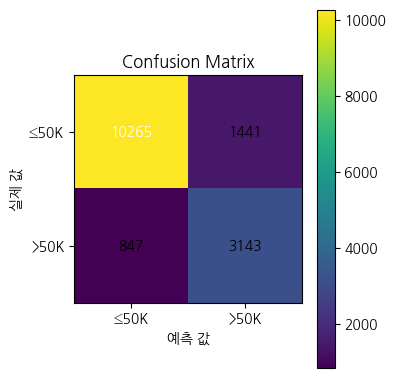

In [15]:
from matplotlib.colors import LogNorm

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['≤50K', '>50K'])
plt.yticks(tick_marks, ['≤50K', '>50K'])

plt.ylabel('실제 값')
plt.xlabel('예측 값')

# 각 칸에 숫자 표시
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


## 8. Feature Importance(변수 중요도) 분석

`predictor.feature_importance(test_df)`를 사용하면  
**어떤 특성(feature)이 연봉 예측에 더 큰 영향을 미치는지** 알 수 있다.

이 정보를 활용하면:
- 어떤 변수들이 중요한지 설명할 수 있고
- 불필요한 변수를 줄이거나,
- 중요한 변수에 대해 추가 분석(EDA)을 할 수 있다.


In [16]:
fi = predictor.feature_importance(test_df)
fi.head()


Computing feature importance via permutation shuffling for 13 features using 5000 rows with 5 shuffle sets...
	18.25s	= Expected runtime (3.65s per shuffle set)
	10.51s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
capital-gain,0.121904,0.006846,0.000001,5,0.136001,0.107807
relationship,0.062987,0.007934,0.000030,5,0.079322,0.046651
education-num,0.056014,0.008271,0.000055,5,0.073044,0.038984
marital-status,0.053466,0.008940,0.000090,5,0.071873,0.035059
occupation,0.048704,0.004933,0.000012,5,0.058862,0.038546


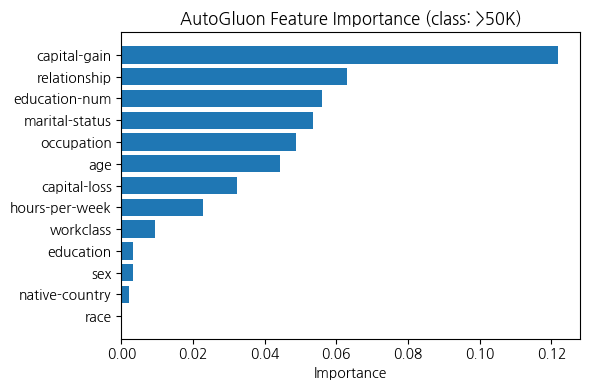

In [17]:
# 중요도 기준으로 정렬 후 시각화
fi_sorted = fi.sort_values("importance", ascending=True)

plt.figure(figsize=(6, max(4, len(fi_sorted) * 0.3)))
plt.barh(fi_sorted.index, fi_sorted["importance"])
plt.title("AutoGluon Feature Importance (class: >50K)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## 9. 정리

이번 노트북에서는 다음 내용을 다루었다.

1. `salary2.csv` 연봉 데이터 불러오기 및 기본 전처리
2. 타깃 변수 `class`를 0/1 이진 변수로 변환
3. 학습 데이터/테스트 데이터 분리 (`train_test_split`)
4. **AutoGluon TabularPredictor**를 이용한 AutoML 분류 모델 학습
5. 리더보드를 통해 여러 모델의 성능 비교
6. Confusion Matrix, Classification Report, ROC-AUC로 모델 평가
7. Feature Importance로 **연봉에 영향을 주는 주요 변수** 해석

> 수업에서 활용할 때는,  
> - 먼저 기존의 `DecisionTree`, `RandomForest` 등을 직접 튜닝해본 뒤  
> - 같은 데이터를 AutoGluon에 넣어 성능 차이와 개발 편의성을 비교해 보는 활동  
> 을 함께 진행하면 학습 효과가 매우 좋다.
